In [1]:
# coding: utf-8
import time
import os
import numpy as np
from sklearn.model_selection import train_test_split

import keras
from keras import metrics
from keras.models import load_model
from keras.preprocessing.sequence import pad_sequences

from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM
from keras.layers.embeddings import Embedding

from datetime import datetime
from gensim.models import word2vec
from collections import *
import pandas as pd
import matplotlib.pyplot as plt

Using TensorFlow backend.


In [2]:
def text_to_index(corpus, word2idx):
    new_corpus = []
    for doc in corpus:
        new_doc = []
        for word in doc:
            try:
                new_doc.append(word2idx[word])
            except:
                new_doc.append(0)
        # new_doc_arr = np.array(new_doc).reshape(1, max_doc_word_length)
        new_doc_arr = np.array(new_doc)
        new_corpus.append( new_doc_arr)
    return np.array(new_corpus)

In [3]:
# Read pickle and split training and testing sets
df = pd.read_pickle('train_reduce.pkl')
train_df, test_df = train_test_split(df, test_size=0.2)

train_texts = train_df['ari_title']
label_list = train_df['price']

test_texts = test_df["ari_title"].values

In [22]:
# Get the word embedding vector
word_vector_model = word2vec.Word2Vec.load("word2vec.model")
word_vectors = word_vector_model.wv
wvv = word_vectors.vocab

vocab_num = len(wvv.items())
wvv_keys_list = list(wvv.keys())
vocab_list = [(word, word_vectors[word]) for word, _ in wvv.items()]

print(word_vector_model, vocab_num)
del word_vector_model, word_vectors, wvv

Word2Vec(vocab=50, size=50, alpha=0.025) 50


In [5]:
# Generate embedding matrix, EMBEDDING_DIM can be found in word2Vec.ipynb
EMBEDDING_DIM = 50
embedding_matrix = np.zeros((vocab_num + 1, EMBEDDING_DIM))
word2idx = {}

for i, vocab in enumerate(vocab_list):
    word, vec = vocab
    embedding_matrix[i + 1] = vec
    word2idx[word] = i + 1

print(embedding_matrix.shape)

(51, 50)


In [6]:
# Calculate max length among all titles for checking
max_title_length = np.max(list(map(len, train_texts)))
print("Max title length is %d among %d titles." % (max_title_length, len(train_texts)))

max_doc_word_length = 150

Max title length is 104 among 11136 titles.


In [7]:
# Create training inputs
x_train_texts_idx = text_to_index(train_df['ari_title'], word2idx)
X_train = pad_sequences(x_train_texts_idx, maxlen= max_doc_word_length)

Y_train = label_list
assert(len(X_train) == len(Y_train))
data_length = len(X_train)

print(X_train.shape, Y_train.shape)

(11136, 150) (11136,)


In [8]:
# Model definition
model = Sequential()
embedding_layer = Embedding(input_dim=embedding_matrix.shape[0], output_dim=EMBEDDING_DIM, weights=[embedding_matrix], 
                            input_length=max_doc_word_length, trainable=False)
model.add(embedding_layer)
model.add(LSTM(16))    

# model.add(Dense(40, activation='relu'))
# model.add(Dense(20, activation='relu'))

model.add(Dense(2000, activation='relu'))
model.add(Dense(500, activation='relu'))
model.add(Dense(200, activation='relu'))
model.add(Dense(50, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 150, 50)           2550      
_________________________________________________________________
lstm_1 (LSTM)                (None, 16)                4288      
_________________________________________________________________
dense_1 (Dense)              (None, 2000)              34000     
_________________________________________________________________
dense_2 (Dense)              (None, 500)               1000500   
_________________________________________________________________
dense_3 (Dense)              (None, 200)               100200    
_________________________________________________________________
dense_4 (Dense)              (None, 50)                10050     
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 51        
Total para

In [9]:
num_epochs = 3 # 50
history = model.fit(x=X_train, y=Y_train, 
                    batch_size=100,  epochs=num_epochs, verbose=1)

Epoch 1/3
11136/11136 [==============================] - 22s 2ms/step - loss: 0.6887 - acc: 0.5515
Epoch 2/3
11136/11136 [==============================] - 20s 2ms/step - loss: 0.6882 - acc: 0.5525
Epoch 3/3
11136/11136 [==============================] - 20s 2ms/step - loss: 0.6875 - acc: 0.5525


In [10]:
model.save('models/my_model.h5') 

accuracy 準確度: 


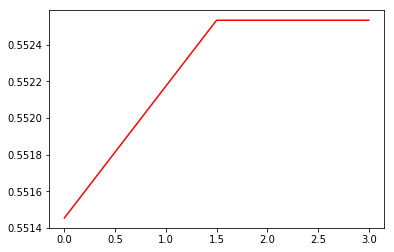

loss 損失函數: 


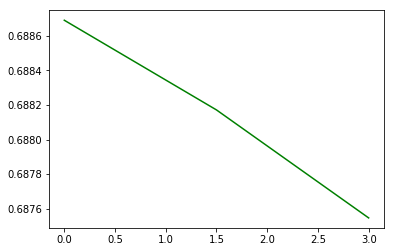

In [11]:
np_loss_history = np.array(history.history['loss'])
np.savetxt("loss_history.txt", np_loss_history, delimiter=",")
loss_history = np.loadtxt("loss_history.txt")

np_acc_history = np.array(history.history['acc'])
np.savetxt("acc_history.txt", np_acc_history, delimiter=",")
acc_history = np.loadtxt("acc_history.txt")

print("accuracy 準確度: ")
fig = plt.figure(1)
ax = plt.axes()
x = np.linspace(0, num_epochs, acc_history.shape[0])
plt.plot(x, acc_history, '-r');  # dotted red
plt.show()


print("loss 損失函數: ")
fig = plt.figure(2)
ax = plt.axes()
x = np.linspace(0, num_epochs, loss_history.shape[0])
plt.plot(x, loss_history, '-g');  # dotted red
plt.show()

In [12]:
# evaluate the model
loss_accuracy = model.evaluate(X_train[0:100], Y_train[0:100], verbose=1)
print(type(loss_accuracy), loss_accuracy)

test_sequences1 = X_train[6377:6577]

predict_res = model.predict(test_sequences1, batch_size= 1, verbose=0)

# final_res = []
# for pre_res in predict_res:
#     final_res.append(pre_res)
# print(predict_res[0:20])

100/100 [==============================] - 0s 2ms/step
<class 'list'> [0.6840612077713013, 0.57]


In [13]:
# 格式化輸出結果成 1 和 0
# 預測結果小於0.5的保存爲0,表示判斷爲會下跌。否則表示上漲或有限小數位的不變。
final_res = []
for value in predict_res:
    final_res.append(int(round(value[0])))

RIGHT_INDEX= 10
for pv,fv in zip(predict_res[0:RIGHT_INDEX], final_res[0:RIGHT_INDEX]):
    print( repr(pv[0]).ljust(15)[:4] , repr(fv).rjust(3)) 

# print(final_res[:20])

0.56   1
0.60   1
0.56   1
0.59   1
0.56   1
0.57   1
0.58   1
0.56   1
0.58   1
0.58   1


In [14]:
# 和真實的股票指數的變化比較，輸出預測的準確率
x1 = final_res[100:]
x2 = []
for val in Y_train[6477:]:
    x2.append(val)

acc_i = 0
for v1,v2 in zip(x1, x2):
    compare_res = (v1 == v2)
    # print(compare_res)
    if compare_res:
        acc_i += 1
print("預測準確率爲:", acc_i / len(x1))

預測準確率爲: 0.56


In [15]:
pre_ress = np.random.randint(2, size=10)
acc_j = 0
# print(pre_ress)
for v1,v2 in zip(pre_ress, x2):
    compare_res = (v1 == v2)
    # print(compare_res)
    if compare_res:
        acc_j += 1
print("random 1 準確率爲:", acc_j / len(pre_ress))

pre_ress = np.random.randint(2, size=10)
acc_j = 0
# print(pre_ress)
for v1,v2 in zip(pre_ress, x2):
    compare_res = (v1 == v2)
    # print(compare_res)
    if compare_res:
        acc_j += 1
print("random 2 準確率爲:", acc_j / len(pre_ress))

pre_ress = np.random.randint(2, size=10)
acc_j = 0
# print(pre_ress)
for v1,v2 in zip(pre_ress, x2):
    compare_res = (v1 == v2)
    # print(compare_res)
    if compare_res:
        acc_j += 1
print("random 3 準確率爲:", acc_j / len(pre_ress))
# print(type(x1), type(x2), x2)

random 1 準確率爲: 0.5
random 2 準確率爲: 0.4
random 3 準確率爲: 0.3


In [16]:
# # result_txt = "result" + str(datetime.now()).split()[1] + ".txt"
# print(len(final_res))
# result_txt = "local_result001" + ".txt"
# ids = 0
# with open(result_txt, 'w') as out:
#     out.write("id,pre_price" + '\n')
#     for value in final_res:
#         out.write(str(ids) + "," + str(int (round(value[0]))) + "," + str(int (round(value[0]))) + '\n')
#         ids += 1